<a href="https://colab.research.google.com/github/sebastianJamesMI/Fellowship_AI_IMDB/blob/main/Sentiment_Analysis_IMDB_Tensorflow_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains code to fine tune BERT by using a layer from Tensorflow Hub. The original code is from the official Tensorflow tutorials:

https://www.tensorflow.org/tutorials/text/classify_text_with_bert


The notebook has the following steps:


    Load the IMDB dataset
    Load a BERT model from TensorFlow Hub
    Build your own model by combining BERT with a classifier
    Train your own model, fine-tuning BERT as part of that
    Save your model and use it to classify sentences



Setup

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 8.0MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 8.5MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 645kB 28.4MB/s 
     |████████████████████████████████| 174kB 36.7MB/s 
     |████████████████████████████████| 706kB 34.4MB/s 
     |████████████████████████████████| 358kB 50.1MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 37.6MB 87kB/s 
     |████████████████████████████████| 1.2MB 56.7MB/s 


In [3]:
import os
import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/Projects/FellowshipAI/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/Projects/FellowshipAI/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/Projects/FellowshipAI/aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 24999 files belonging to 3 classes.
Using 20000 files for training.
Found 24999 files belonging to 3 classes.
Using 4999 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
##examining some reviews
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'This Is Pretty Funny. "Saturday The 12th", a?... Great Work... I Laughed Every Minute of the movie... This Is Like "Scary Movie" for the 1980\'s. great STUDENT BODIES-styled gags...<br /><br />Too Bad This Isn\'t On Video... But You Can Still Watch It on FLIX...'
Label : 0 (neg)
Review: b'As a big fan of David Mamet\'s films and plays, especially his first film House of Games that also starred Joe Mantegna, I was expecting great things from this film. Instead, I found myself annoyed by the film\'s superficiality and lack of credibility. Racial slurs are thrown about without any feeling or meaning behind them, in the hopes of setting up a racial tension that for me never materialized. Identity is totally reevaluated and men become "heroes" for no apparent reason. Because of his oaths taken as a cop, the lead character adamantly refuses to perform one relatively small action that would harm no one and could possibly save lives, and yet performs another action which is very viol

In [18]:
## Loading models from Tensorflow Hub
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [19]:
## Preprocessing model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [20]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [21]:
## Defining Model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

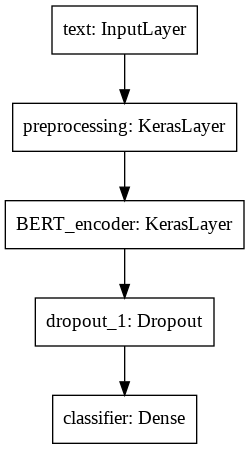

In [22]:
classifier_model = build_classifier_model()
classifier_model.summary()
tf.keras.utils.plot_model(classifier_model)


In [24]:
## Model Training

In [25]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

##optimizer
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [26]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [27]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 161s 249ms/step - loss: 0.6112 - binary_accuracy: 0.6434 - val_loss: 0.3649 - val_binary_accuracy: 0.8256
Epoch 2/5
625/625 [==============================] - 155s 247ms/step - loss: 0.3646 - binary_accuracy: 0.8309 - val_loss: 0.3533 - val_binary_accuracy: 0.8510
Epoch 3/5
625/625 [==============================] - 155s 248ms/step - loss: 0.2751 - binary_accuracy: 0.8804 - val_loss: 0.4053 - val_binary_accuracy: 0.8426
Epoch 4/5
625/625 [==============================] - 155s 247ms/step - loss: 0.2076 - binary_accuracy: 0.9155 - val_loss: 0.4396 - val_binary_accuracy: 0.8556
Epoch 5/5
625/625 [==============================] - 155s 249ms/step - loss: 0.1636 - binary_accuracy: 0.9374 - val_loss: 0.4908 - val_binary_accuracy: 0.8560


In [ ]:
## Model Evaluation
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


 22/782 [..............................] - ETA: 1:19:55 - loss: 0.4927 - binary_accuracy: 0.8523

In [ ]:
## The above model was trained only for one epoch. With further training, higher accuracy can be obtained. 